In [47]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, log_loss, confusion_matrix

In [2]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [4]:
X_train = df_train.drop(['vitoria','ano_campeonato','rodada'] ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(['vitoria','ano_campeonato','rodada'] ,axis=1)
y_test = df_test['vitoria']

In [5]:
cat_ord = ['tecnico_enc', 'time_enc', 'time_adversario_enc'] # Categoricas Ordinais (Resultado do Encoding)
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord]

In [6]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Para variaveis de encoding, imputa mising com a media
            ('scaler', MinMaxScaler())
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers)

        return preprocessor
    else:
        return None

In [7]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)
# joblib.dump(preprocessor, '../artifacts/preprocessor.pkl')
X_sel_train = preprocessor_1.transform(X_train)
X_sel_train.columns = X_train.columns

X_sel_test = preprocessor_1.transform(X_test)
X_sel_test.columns = X_test.columns

In [8]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [9]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [10]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

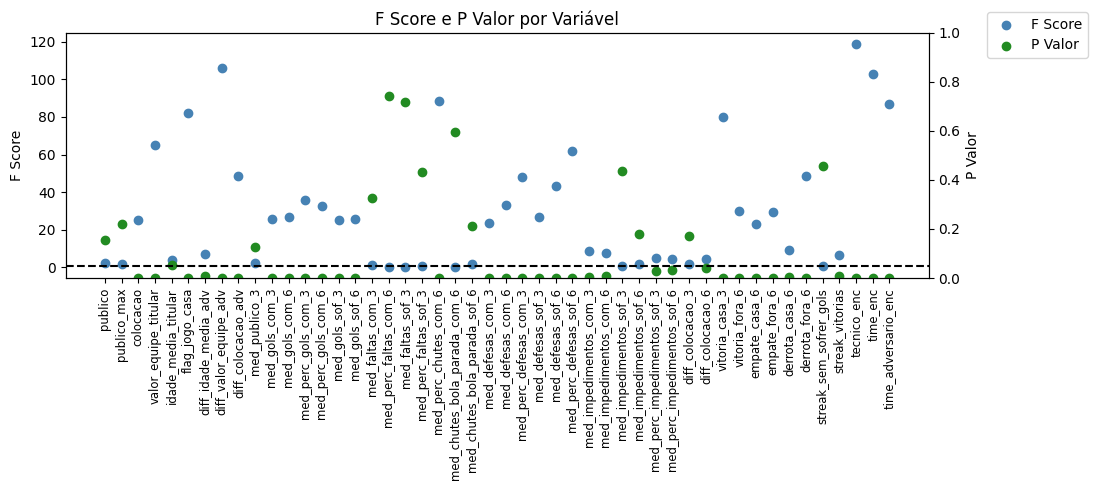

---- Variáveis em Ordem Descrescente de Força ----
tecnico_enc
diff_valor_equipe_adv
time_enc
med_perc_chutes_com_6
time_adversario_enc
flag_jogo_casa
vitoria_casa_3
valor_equipe_titular
med_perc_defesas_sof_6
diff_colocacao_adv
derrota_fora_6
med_perc_defesas_com_3
med_defesas_sof_6
med_perc_gols_com_3
med_defesas_com_6
med_perc_gols_com_6
vitoria_fora_6
empate_fora_6
med_defesas_sof_3
med_gols_com_6
med_gols_sof_6
med_gols_com_3
med_gols_sof_3
colocacao
med_defesas_com_3
empate_casa_6
derrota_casa_6
med_impedimentos_com_3
med_impedimentos_com_6
diff_idade_media_adv
streak_vitorias
med_perc_impedimentos_sof_3
med_perc_impedimentos_sof_6
diff_colocacao_6


In [11]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(10, 5))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.10, 0.98))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\3785735621.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')


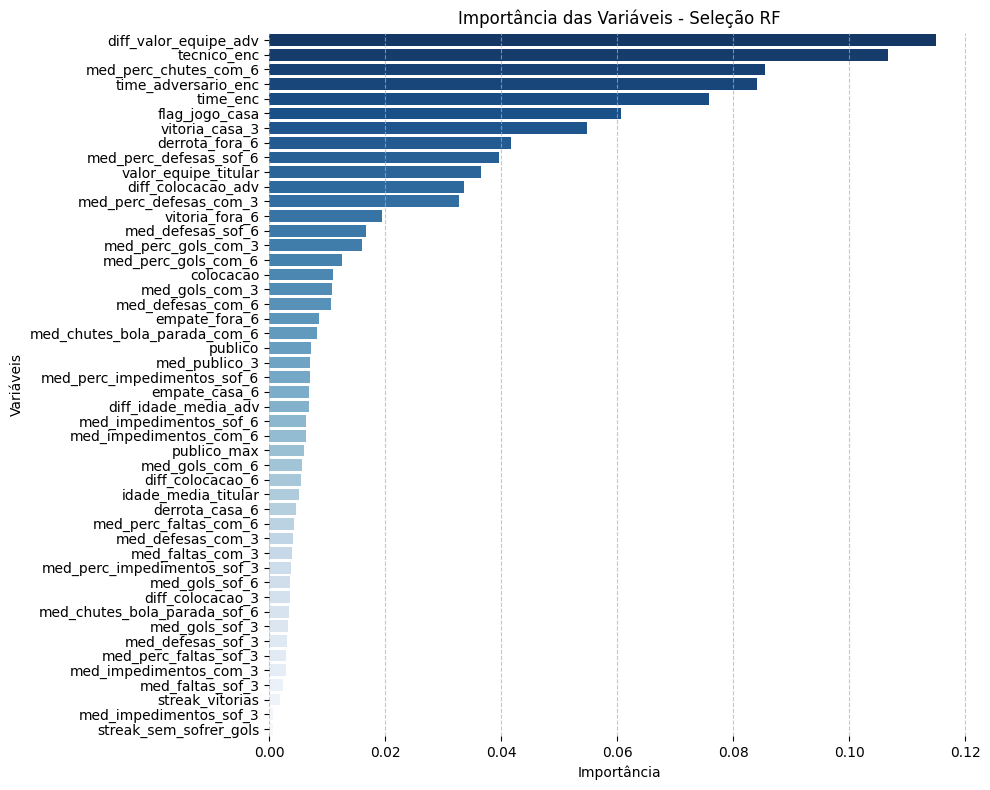

In [12]:
# Crie um modelo de RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Treine o modelo
rf_model.fit(df_filter, y_train)

# Obtenha a importância das características
feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 12 variáveis (med_perc_defesas_com_3 pra cima). Assim, podemos adotar um corte na importancia de 0.03

In [13]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.03, 'RF_SEL'] = 1

Agora, vamos observar como se comporta a precisão de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

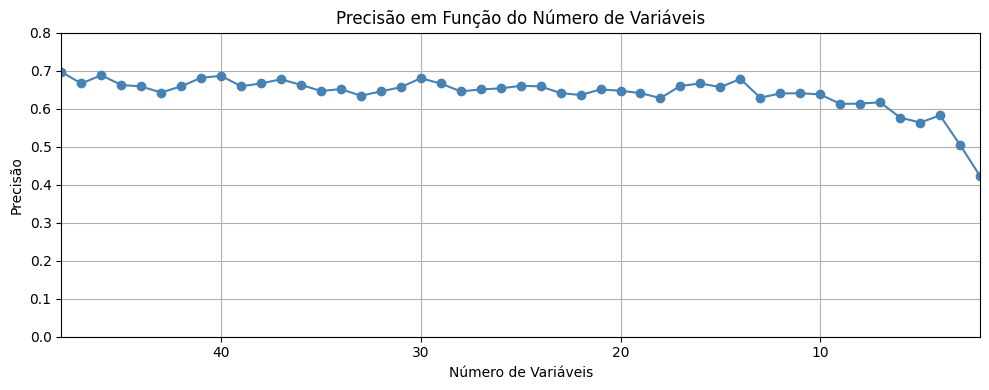

In [14]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
precision_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]    
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    
    precision = precision_score(y_test, y_pred)
    num_features_list.append(i)
    precision_list.append(precision)

plt.figure(figsize=(10, 4))
plt.plot(num_features_list, precision_list, marker='o', linestyle='-', color='steelblue')
plt.xlabel('Número de Variáveis')
plt.ylabel('Precisão')
plt.title('Precisão em Função do Número de Variáveis')
plt.grid(True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

Nota-se que a partir de 15 variáveis a precisão do Modelo Baseline começa a perder força.

In [15]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')

In [16]:
df_compara_sel

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
0,publico,2.009598,1.564669e-01,0,0.007262,0
1,publico_max,1.506066,2.198888e-01,0,0.006076,0
2,colocacao,25.091170,5.962596e-07,1,0.010961,0
3,valor_equipe_titular,65.250074,1.145392e-15,1,0.036461,1
4,idade_media_titular,3.717727,5.398302e-02,0,0.005165,0
5,flag_jogo_casa,82.104202,3.061132e-19,1,0.060586,1
6,diff_idade_media_adv,7.157948,7.525829e-03,1,0.006852,0
7,diff_valor_equipe_adv,106.116062,2.886323e-24,1,0.115044,1
8,diff_colocacao_adv,48.636995,4.204948e-12,1,0.033597,1
9,med_publico_3,2.317064,1.281239e-01,0,0.006998,0


In [17]:
vars_final = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas 12 que foram selecionadas por RandomForest

In [18]:
vars_final

['valor_equipe_titular',
 'flag_jogo_casa',
 'diff_valor_equipe_adv',
 'diff_colocacao_adv',
 'med_perc_chutes_com_6',
 'med_perc_defesas_com_3',
 'med_perc_defesas_sof_6',
 'vitoria_casa_3',
 'derrota_fora_6',
 'tecnico_enc',
 'time_enc',
 'time_adversario_enc']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

In [78]:
vars_final = ['valor_equipe_titular',
 'flag_jogo_casa',
 'diff_valor_equipe_adv',
 'diff_colocacao_adv',
 'med_perc_chutes_com_6',
 'med_perc_defesas_com_3',
 'med_perc_defesas_sof_6',
 'vitoria_casa_3',
 'derrota_fora_6',
 'tecnico_enc',
#  'time_enc',
#  'time_adversario_enc'
 ]

num_finais = ['valor_equipe_titular', 'flag_jogo_casa', 'diff_valor_equipe_adv', 'diff_colocacao_adv',
              'med_perc_chutes_com_6', 'med_perc_defesas_com_3', 'med_perc_defesas_sof_6', 'vitoria_casa_3','derrota_fora_6']

cat_ord_finais = ['tecnico_enc', 
                #   'time_enc', 
                #   'time_adversario_enc'
                  ]

preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização. Podemos escolher a precisão, que mede a proporção de todas as previsões corretas que o modelo fez. Além disso, podemos utilizar uma abordagem de retorno para apostas através da métrica ROI (Return Over Investment)

Sendo assim, vamos combinar a precisão e o ROI na nossa métrica de maximização, adotando pesos para ambos.
Em resumo:

-   O ROI mede a lucratividade financeira, indicando diretamente a capacidade do modelo de gerar retornos sobre o investimento.
-   A precisão é ideal para evitar falsos positivos. Com isso, evitariamos perdas financeiras ao apostar na vitoria de um determinado jogo.

Para cada jogo vamos considerar que será apostado $10 e que para cada ganho, tenha um lucro de 10% sobre o valor apostado

In [20]:
def weighted_profit_loss(y_true, y_pred, bet=10, win_weight=1, loss_weight=2): 

    
    correct_pred = accuracy_score(y_true, y_pred) 
    incorrect_pred = 1 - correct_pred  

    wins = correct_pred * len(y_true)  # Total de vitorias
    losses = incorrect_pred * len(y_true)  # Total de derrotas

    wpl = wins * win_weight - losses * loss_weight

    net_gain_loss = wpl * bet

    return net_gain_loss

In [21]:
def roi_score(y_true, y_pred_proba, stake_per_bet=10):
    '''
    Calcula o retorno sobre o investimento (ROI)
    '''   

    y_pred = (y_pred_proba >= 0.5).astype(int) # Limiar de 0.5

    total_bets = len(y_true)
    total_wins = sum(y_true * y_pred)

    total_payouts = total_wins * stake_per_bet * 1.1  # Considerando 10% de lucro em vitorias
    total_staked = total_bets * stake_per_bet # Total apostado nao considerando lucros
    net_profit = total_payouts - total_staked
    
    return (net_profit / total_staked)

In [51]:
def cost_sensitive_precision(y_true, y_pred, tp_weight=1, fp_weight=5):
    '''
    Calcula a Precisao com pesos aplicados no TP e FP de 
    forma a penalizar falsos positivos.

    Este método é util quando temos classes desbalanceada. No nosso caso, a taxa de vitoria é 30%
    '''    

    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]  
    fp = cm[0, 1] 

    weighted_tp = -tp_weight*tp
    weighted_fp = -fp_weight*fp    

    cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)

    if np.isnan(cost_sensitive_precision):
        return 0
    else:
        return cost_sensitive_precision

In [79]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [80]:
df_train_f.shape

(1947, 11)

In [81]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 500),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
            max_iter=trial.suggest_int('max_iter', 100, 500),
            tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 500),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 500),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )

    tscv = TimeSeriesSplit(n_splits=5)

    metrics_folds = []    
    for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

        train = df_train_f.iloc[train_index]
        X_train = train.drop(['vitoria'],axis=1)
        y_train = train['vitoria']
        valid = df_train_f.iloc[test_index]
        X_valid = valid.drop(['vitoria'],axis=1)
        y_valid = valid['vitoria']

        model.fit(X_train, y_train)

        pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]        
        w_precision = cost_sensitive_precision(y_valid, pred)
        roi = roi_score(y_valid, y_pred_proba)        
        result = 0.8 * w_precision + 0.2 * roi

        metrics_folds.append(result)
               
    return np.mean(metrics_folds)   


models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='maximize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    best_value = round(study.best_value,2)

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

[I 2024-01-03 22:37:52,340] A new study created in memory with name: no-name-09972d9f-72df-4d09-8c87-0eb1eabe012f


------ RandomForest ------


[I 2024-01-03 22:37:59,768] Trial 0 finished with value: -0.0034122339591437234 and parameters: {'n_estimators': 218, 'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 48, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 0 with value: -0.0034122339591437234.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
[I 2024-01-03 22:38:09,374] Trial 1 finished with value: -0.04234476428034592 and parameters: {'n_estimators': 321, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 250, 'min_samples_leaf': 22, 'bootstrap': False}. Best is trial 0 with value: -0.0034122339591437234.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
[I 2024-01-03 22:38:14,013] Trial 2 finished wit

------ LogisticRegression ------


[I 2024-01-03 22:43:02,898] Trial 1 finished with value: 0.009268639928923194 and parameters: {'C': 157.41890047456639, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 433, 'tol': 0.00026587543983272726}. Best is trial 1 with value: 0.009268639928923194.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precisio

------ LGBM ------


[I 2024-01-03 22:43:09,688] Trial 0 finished with value: -0.02101224944651951 and parameters: {'n_estimators': 218, 'max_depth': 8, 'learning_rate': 0.0483437145318464, 'num_leaves': 94, 'min_data_in_leaf': 39, 'bagging_fraction': 0.16443457513284063, 'reg_alpha': 0.0014936568554617625, 'reg_lambda': 0.39676050770529875}. Best is trial 0 with value: -0.02101224944651951.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Tem

------ NaiveBayes ------


[I 2024-01-03 22:43:48,044] Trial 2 finished with value: -0.008782765682586161 and parameters: {'var_smoothing': 4.570563099801454e-06}. Best is trial 0 with value: -0.008782765682586161.
[I 2024-01-03 22:43:48,143] Trial 3 finished with value: -0.008782765682586161 and parameters: {'var_smoothing': 9.846738873614562e-07}. Best is trial 0 with value: -0.008782765682586161.
[I 2024-01-03 22:43:48,212] Trial 4 finished with value: -0.008782765682586161 and parameters: {'var_smoothing': 6.02688912868252e-09}. Best is trial 0 with value: -0.008782765682586161.
[I 2024-01-03 22:43:48,289] Trial 5 finished with value: -0.008782765682586161 and parameters: {'var_smoothing': 6.0252157362038635e-09}. Best is trial 0 with value: -0.008782765682586161.
[I 2024-01-03 22:43:48,365] Trial 6 finished with value: -0.008782765682586161 and parameters: {'var_smoothing': 1.9517224641449526e-09}. Best is trial 0 with value: -0.008782765682586161.
[I 2024-01-03 22:43:48,444] Trial 7 finished with value: -0

------ AdaBoostClassifier ------


[I 2024-01-03 22:43:58,862] Trial 0 finished with value: -0.027978598584355217 and parameters: {'n_estimators': 218, 'learning_rate': 0.36808608148776095}. Best is trial 0 with value: -0.027978598584355217.
[I 2024-01-03 22:44:11,566] Trial 1 finished with value: -0.014542156252841004 and parameters: {'n_estimators': 380, 'learning_rate': 0.04128205343826222}. Best is trial 1 with value: -0.014542156252841004.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weigh

------ KNN ------


[I 2024-01-03 22:50:04,500] Trial 0 finished with value: -0.01527653010103755 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: -0.01527653010103755.
[I 2024-01-03 22:50:04,737] Trial 1 finished with value: -0.03837359777467706 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: -0.01527653010103755.
[I 2024-01-03 22:50:04,977] Trial 2 finished with value: -0.009752124137304424 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: -0.009752124137304424.
[I 2024-01-03 22:50:05,222] Trial 3 finished with value: -0.01808159272283959 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: -0.009752124137304424.
[I 2024-01-03 22:50:05,441] Trial 4 finished with value: -0.008169147434252344 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: -0.008169147434252344.
[I 2024-01-03 22:50:05,

------ SVC ------


C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
[I 2024-01-03 22:50:17,047] Trial 0 finished with value: -0.12827814088598402 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 506.1576888752306, 'shrinking': True, 'probability': True}. Best is trial 0 with value: -0.12827814088598402.
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_pre

------ DecisionTree ------


C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
C:\Users\matcg\AppData\Local\Temp\ipykernel_16980\2261926195.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)
[I 2024-01-03 22:56:55,624] Trial 2 finished with value: -0.17109081092754563 and parameters: {'max_depth': 1, 'min_samples_split': 98, 'max_leaf_nodes': 26, 'criterion': 'gini'}. Best is trial 0 with value: -0.00800013098179364.
[I 2024-01-03 22:56:55,723] Trial 3 finished with value: -0.02084178905542135 and parameters: {'max_depth': 2, 'min_samples_split': 34, 'max_leaf_nodes': 17, 'criterion': 'gini

In [82]:
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
6,SVC,"{'C': 0.2527809940933973, 'kernel': 'linear', ...",0.17
1,LogisticRegression,"{'C': 0.12099967773941854, 'penalty': 'l2', 's...",0.13
0,RandomForest,"{'n_estimators': 459, 'max_depth': 2, 'criteri...",0.04
2,LGBM,"{'n_estimators': 406, 'max_depth': 6, 'learnin...",0.03
4,AdaBoostClassifier,"{'n_estimators': 307, 'learning_rate': 0.01019...",0.02
5,KNN,"{'n_neighbors': 18, 'weights': 'uniform', 'p': 2}",0.00
7,DecisionTree,"{'max_depth': 4, 'min_samples_split': 84, 'max...",-0.00
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},-0.01


In [53]:
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.05616364572130304, 'penalty': 'l2', 's...",0.17
6,SVC,"{'C': 0.5450293694558254, 'kernel': 'linear', ...",0.15
0,RandomForest,"{'n_estimators': 355, 'max_depth': 3, 'criteri...",0.14
2,LGBM,"{'n_estimators': 424, 'max_depth': 1, 'learnin...",0.09
4,AdaBoostClassifier,"{'n_estimators': 227, 'learning_rate': 0.00899...",0.04
5,KNN,"{'n_neighbors': 14, 'weights': 'uniform', 'p': 1}",0.03
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},-0.01
7,DecisionTree,"{'max_depth': 5, 'min_samples_split': 83, 'max...",-0.01


In [85]:
comparison_df.iloc[1]['best_params']

{'C': 0.12099967773941854,
 'penalty': 'l2',
 'solver': 'liblinear',
 'max_iter': 185,
 'tol': 0.001442549142814029}

O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi o Support Vector Machine (SVM). Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [90]:
model_f = SVC(C=0.2527809940933973,
              kernel='linear',
              gamma=17.855441364511133,
              shrinking=True,
              probability=True,
              random_state=42)

model_f.fit(X_train_f, y_train)
pred_f = model_f.predict(X_test_f)

print(weighted_profit_loss(y_test, pred_f))
print(roi_score(y_test, pred_f))
print(cost_sensitive_precision(y_test, pred_f))
print(precision_score(y_test, pred_f))

370.0
-0.8867065868263473
0.2598187311178248
0.6370370370370371


In [91]:
model_f = LogisticRegression(C=0.05616364572130304,
              penalty='l2',
              solver='saga',
              max_iter=360,
              tol= 0.0004774131020975513,
              random_state=42)

model_f.fit(X_train_f, y_train)
pred_f = model_f.predict(X_test_f)

print(weighted_profit_loss(y_test, pred_f))
print(roi_score(y_test, pred_f))
print(cost_sensitive_precision(y_test, pred_f))
print(precision_score(y_test, pred_f))

220.0
-0.8985628742514971
0.25496688741721857
0.6311475409836066


In [92]:
model_f = LogisticRegression(C=0.12099967773941854,
              penalty='l2',
              solver='liblinear',
              max_iter=185,
              tol= 0.001442549142814029,
              random_state=42)

model_f.fit(X_train_f, y_train)
pred_f = model_f.predict(X_test_f)

print(weighted_profit_loss(y_test, pred_f))
print(roi_score(y_test, pred_f))
print(cost_sensitive_precision(y_test, pred_f))
print(precision_score(y_test, pred_f))

729.9999999999994
-0.8669461077844312
0.27977839335180055
0.6601307189542484
